# Part 1: Training a Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [3]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))

In [4]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

In [5]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)

In [6]:
y_df_stack = output_train.velsurf_mag.stack(dim=["y", "x"])


In [7]:
y_df_stack

<xarray.DataArray 'velsurf_mag' (time: 1049, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) float64 -1.249e+05 -1.248e+05 ... -2e+04 -1.99e+04
  * dim      (dim) object MultiIndex
  * y        (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x        (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

In [8]:
y_train_df = pd.DataFrame(y_df_stack.to_pandas())

In [9]:
y_train_df = y_train_df.fillna(0)

In [10]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

In [11]:
print(X_train.shape,y_train.shape)

(1049, 1) (1049, 145161)


In [12]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [13]:
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 32
model_num      = 1

In [14]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2022-11-16 14:11:14.260187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 145161)            9435465   
                                                                 
Total params: 9,448,073
Trainable params: 9,448,073
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
27/27 [==============================] - 5s 137ms/step - loss: 185.5204 - val_loss: 123.7432
Epoch 2/50
27/27 [==============================] - 3s 111ms/step - loss: 181.4314 - val_loss: 105.0020
Epoch 3/50
27/27 [==============================] - 3s 102ms/step - loss: 158.5684 - val_loss: 117.1931
Epoch 4/50
27/27 [==============================] - 3s 98ms/step - loss: 138.4069 - val_loss: 100.6862
Epoch 5/50
27/27 [==============================] - 2s 92ms/step - loss: 130.1238 - val_loss: 101.9747
Epoch 6/50
27/27 [==============================] - 3s 96ms/step - loss: 123.7096 - val_loss: 99.7824
Epoch 7/50
27/27 [==============================] - 3s 99ms/step - loss: 119.5392 - val_loss: 108.6030
Epoch 8/50
27/27 [==============================] - 3s 106ms/step - loss: 118.2850 - val_loss: 98.7221
Epoch 9/50
27/27 [==============================] - 3s 99ms/step - loss: 116.9880 - val_loss: 94.0718
Epoch 10/50
27/27 [==============================] - 3s 101ms/step - los

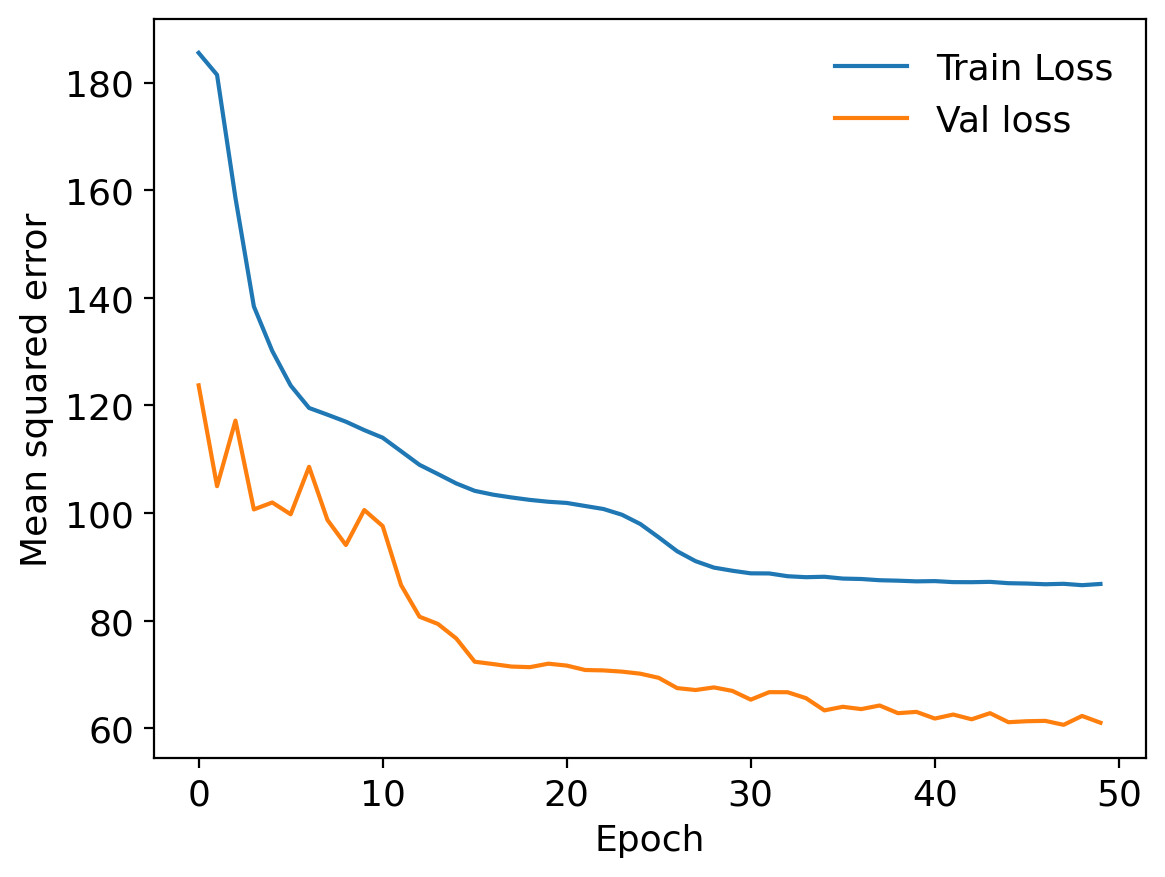

In [17]:
plot_history(history)

In [18]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [19]:
model.save(os.path.join(model_path,'NN_model_1_member.h5'))

## Testing

In [20]:
model = load_model(os.path.join(model_path,'NN_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [21]:
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [22]:
y_test_df = pd.DataFrame(output_test.velsurf_mag.stack(dim=["y", "x"]).to_pandas()).fillna(0)

In [23]:
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

In [24]:
y_test_pre = model.predict(X_test)


7/7 [==============================] - 0s 22ms/step


In [25]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.index.values.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': y_test_df.index.values, 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [26]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:      (time: 200, y: 381, x: 381)
Coordinates:
  * time         (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... 0.0 50.0
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 1.417 3.095 -1.957 ... -2.827 -1.115

In [27]:
y_true =  y_test_df.unstack().to_xarray()

In [28]:
y_true

<xarray.DataArray (y: 381, x: 381, time: 200)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * time     (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... -100.0 0.0 50.0

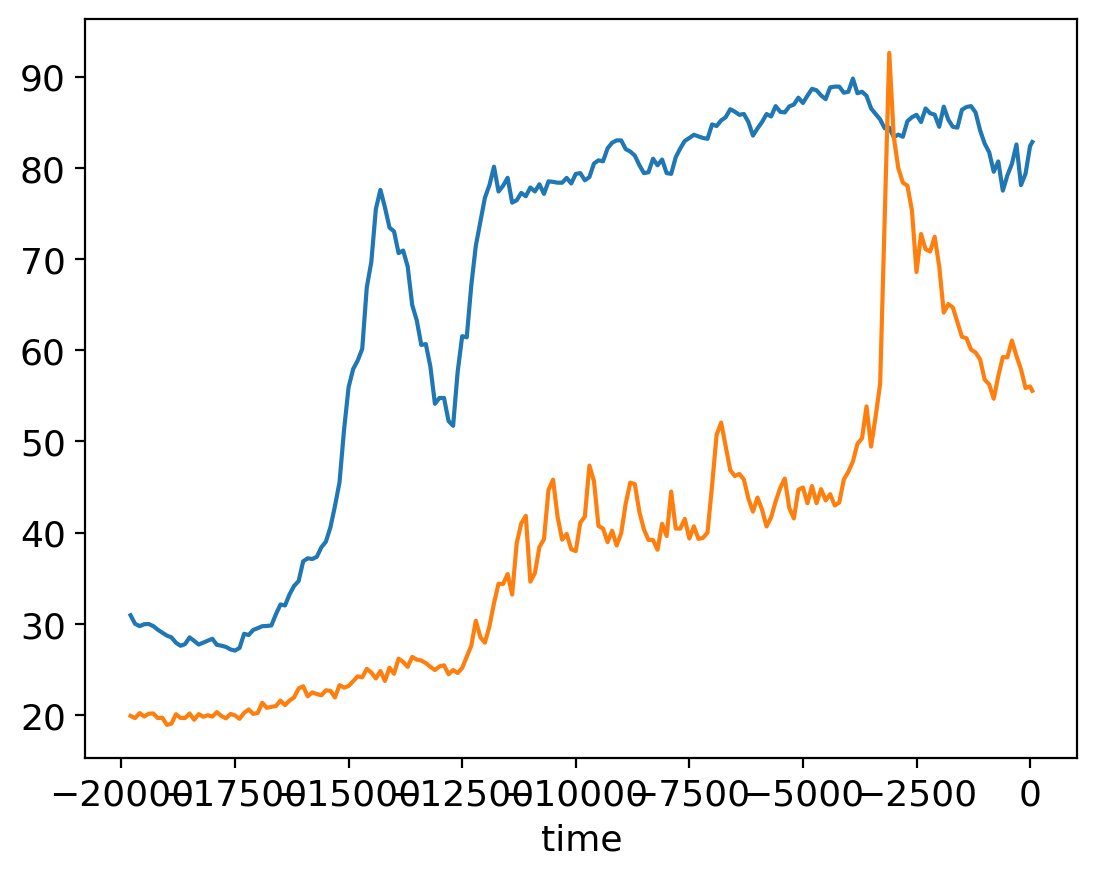

In [29]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

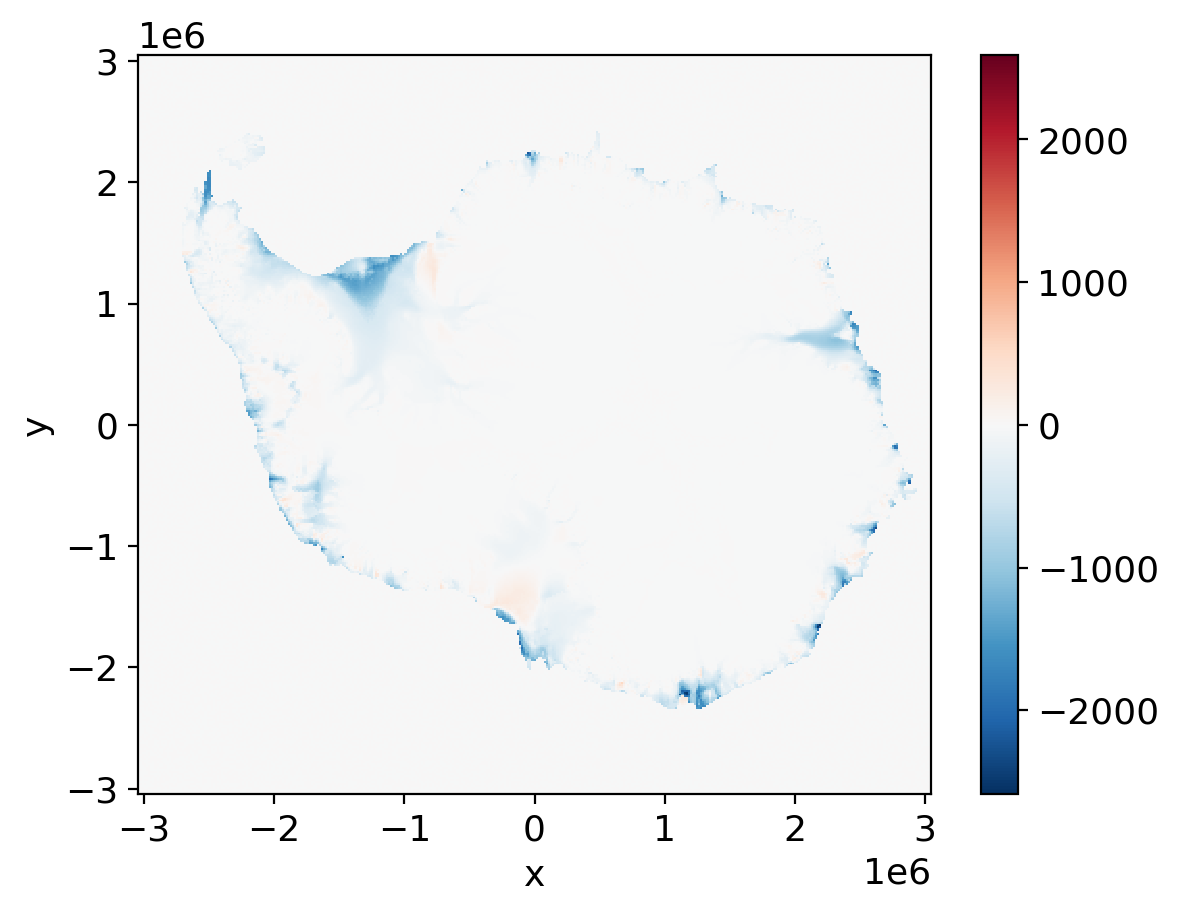

In [30]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

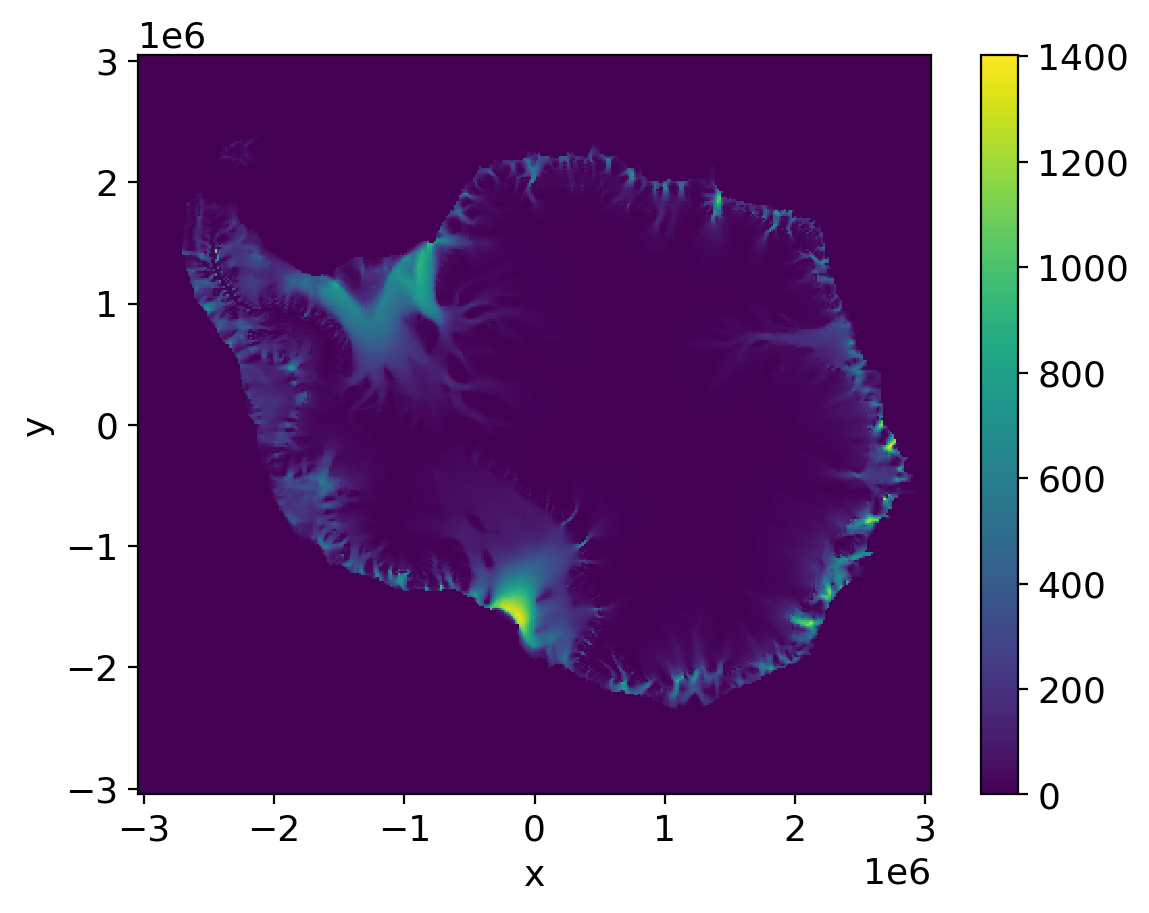

In [31]:
y_true.mean(dim='time').plot()

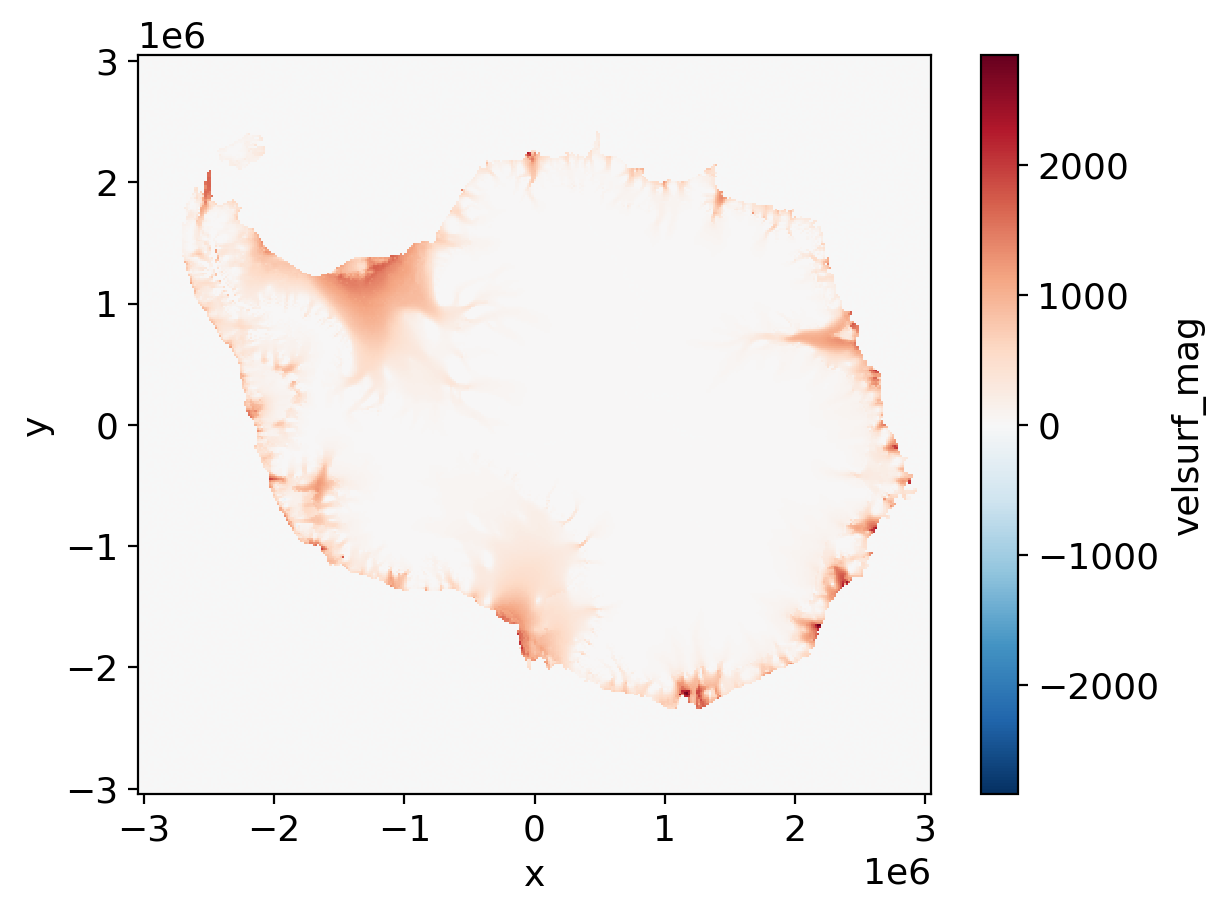

In [32]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()

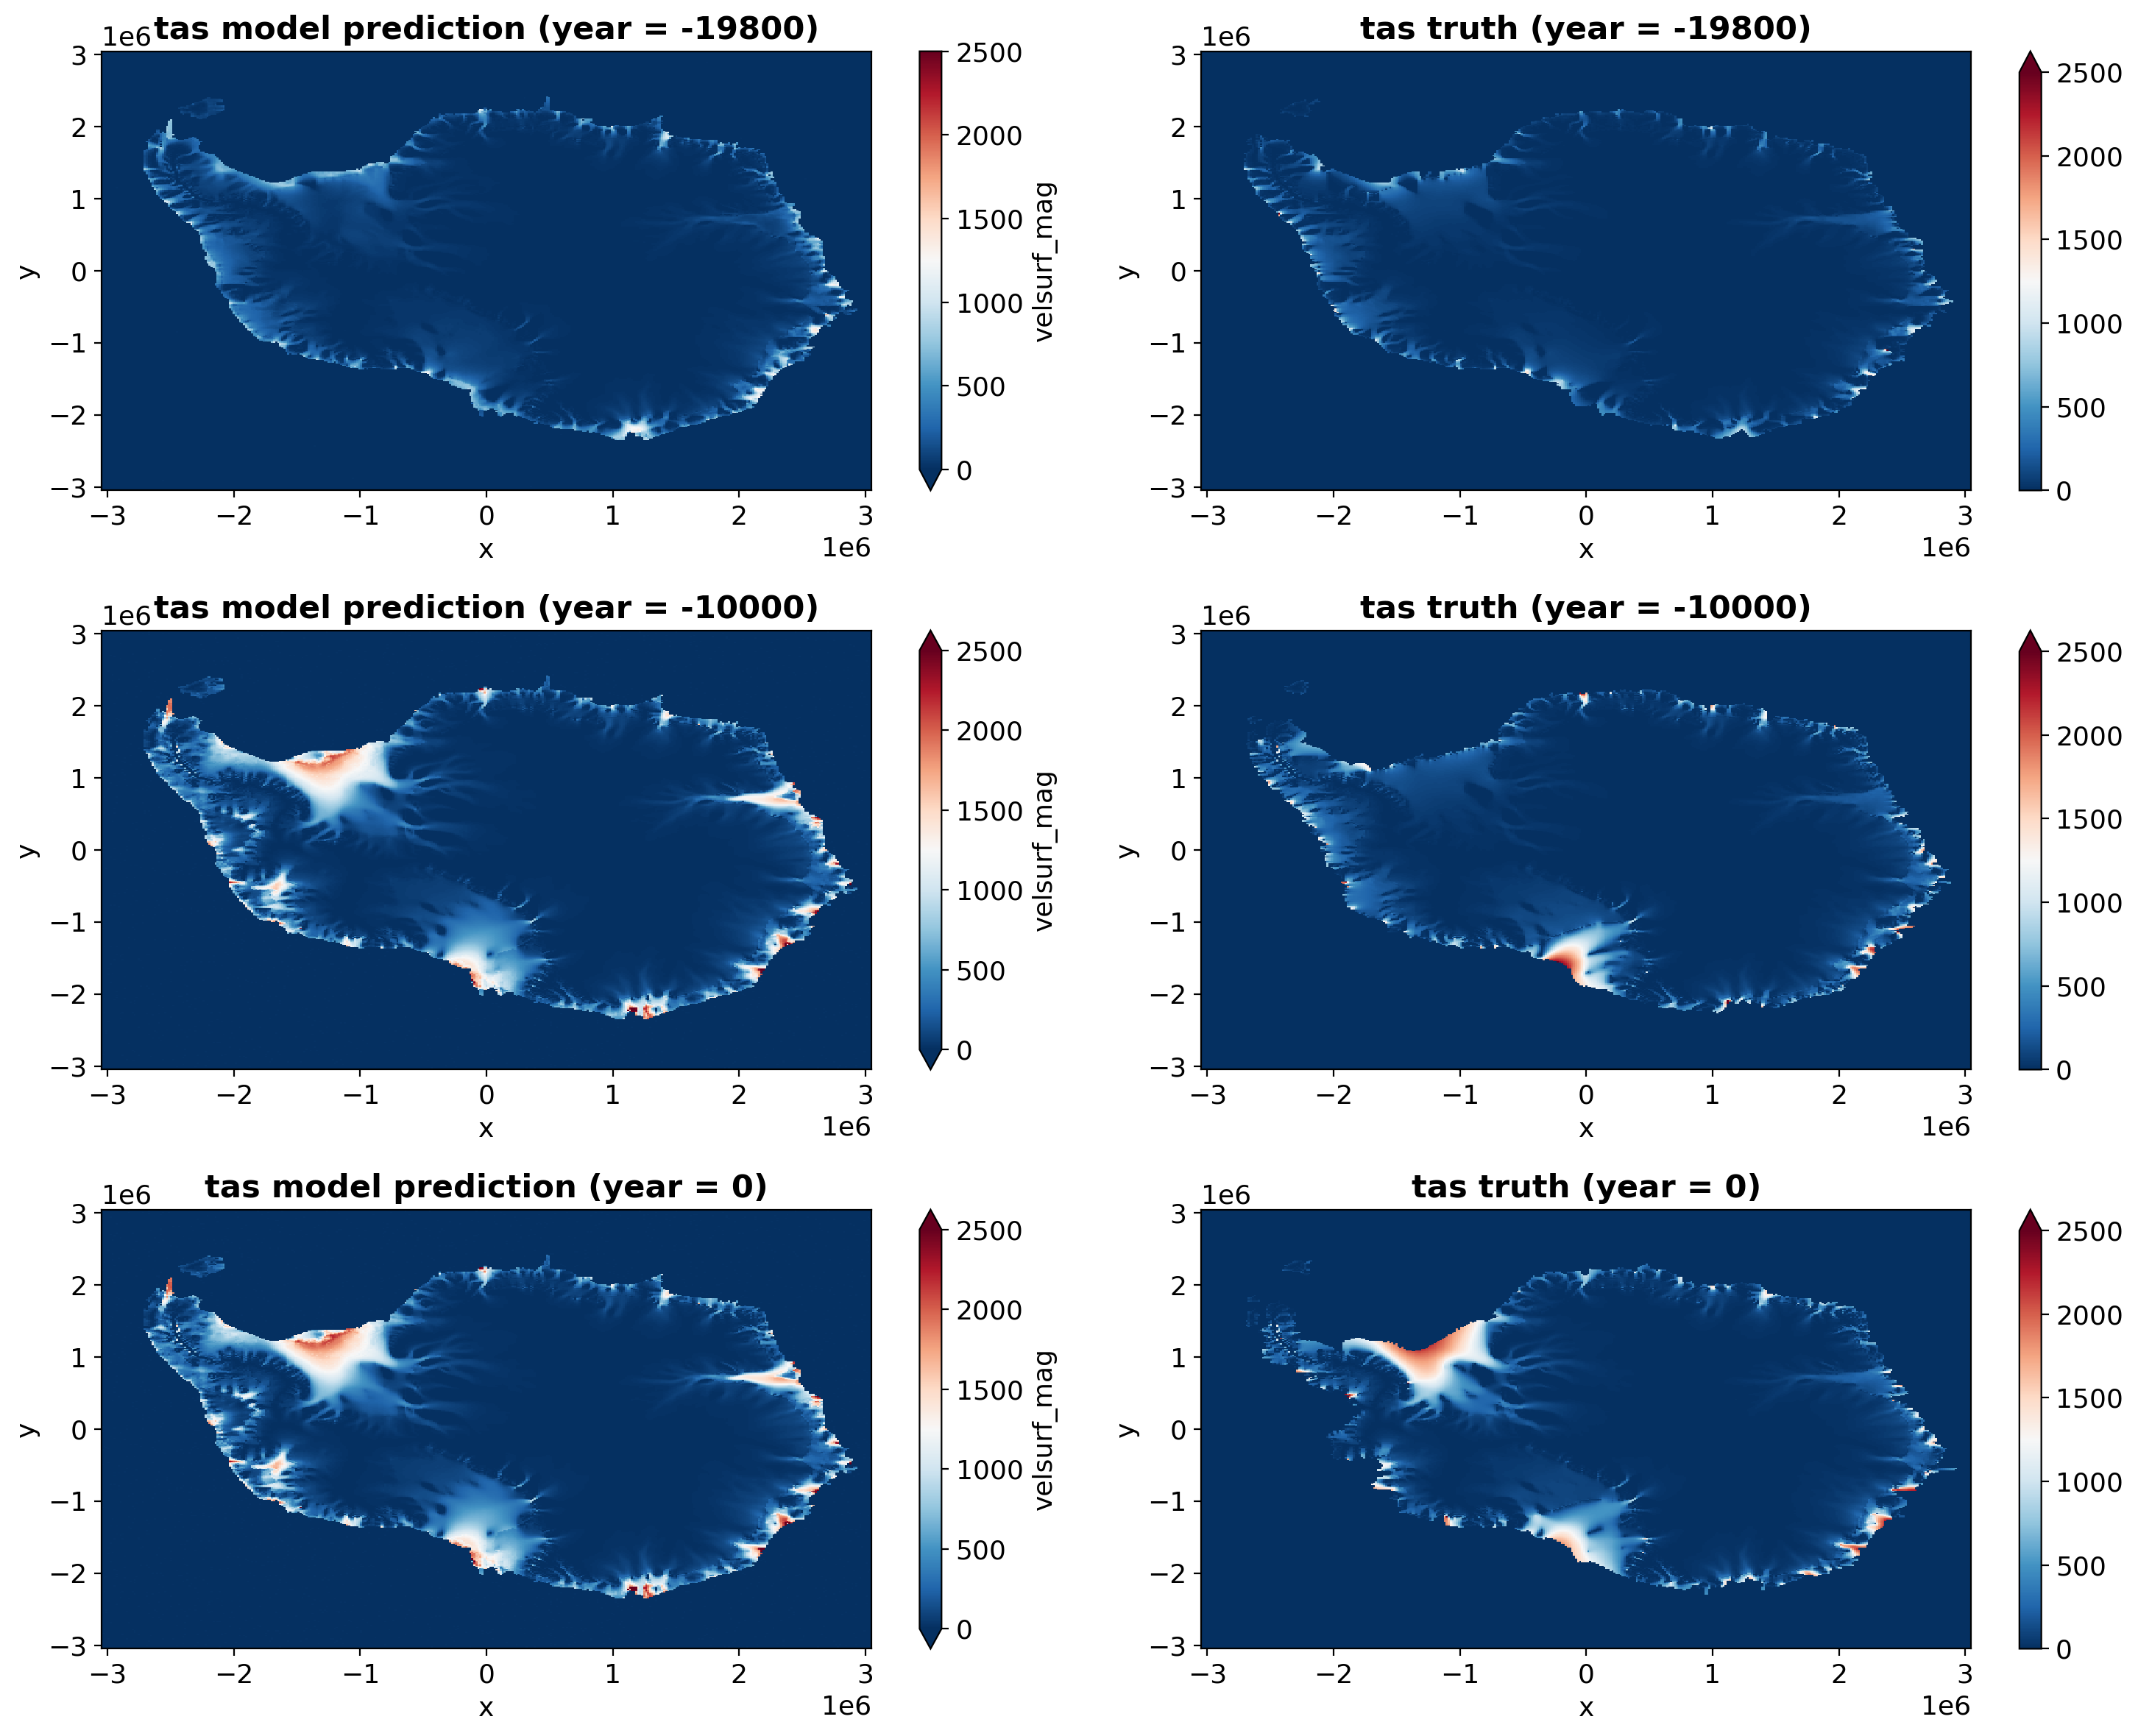

In [33]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [-19800, -10000, 0]
vmin, vmax    = 0, 2500
cmap = 'RdBu_r'
y_test_pre_xr.velsurf_mag.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre_xr.velsurf_mag.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_true.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()